# Baseline Model

### load data

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

path = '/Users/User/Desktop/Project601/'
data = pd.read_csv(path + 'train_labels.csv')
train_path = path + 'train/'
test_path = path + 'test/'
# quick look at the label stats
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [2]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


### Take subset of data and balance the data

In [3]:
SAMPLE_SIZE = 10000
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = data[data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
# filter out class 1
df_1 = data[data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)
# concat the dataframes
data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# check
data['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

### shuffle data

In [4]:
# random sampling
shuffled_data = shuffle(data)

### show picture

In [5]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

### Image Augumentation

In [19]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    
    return rgb_img

### train the model

In [7]:
from sklearn.model_selection import train_test_split

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
train_df = data.set_index('id')

#If removing outliers, uncomment the four lines below
#print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0]))
#train_df = train_df.drop(labels=too_dark_idx, axis=0)
#train_df = train_df.drop(labels=too_bright_idx, axis=0)
#print('After removing outliers we have {0} training samples.'.format(train_df.shape[0]))

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

In [8]:
# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = densenet169                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

In [9]:
# create dataframe for the fastai loader
train_dict = {'name': train_path + train_names, 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])


In [15]:
# use a small sample of test set
df_test = df_test.sample(20000)

In [16]:
len(df_test)

20000

In [20]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn.replace('/./','').replace('//','/'))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))
    

In [21]:
# Create ImageDataBunch using fastai data block API
imgDataBunch = (MyImageItemList.from_df(path='/', df=df, suffix='.tif')
        #Where to find the data?
        .split_by_idx(val_idx)
        #How to split in train/valid?
        .label_from_df(cols='label')
        #Where are the labels?
        .add_test(MyImageItemList.from_df(path='/', df=df_test))
        #dataframe pointing to the test set?
        .transform(tfms=[[],[]], size=sz)
        # We have our custom transformations implemented in the image loader but we could apply transformations also here
        # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        .databunch(bs=BATCH_SIZE)
        # convert to databunch
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
        # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.
       )

In [ ]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return cnn_learner(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()

#### We want to select the largest weight decay that gets to a low loss and has the highest learning rate before shooting up. 

epoch,train_loss,valid_loss,accuracy,time
0,0.520750,0.469120,0.805500,2:51:36
1,0.344055,0.395654,0.853250,2:41:29
2,0.278488,0.287709,0.882000,2:51:18
3,0.243743,0.243537,0.902000,2:37:34


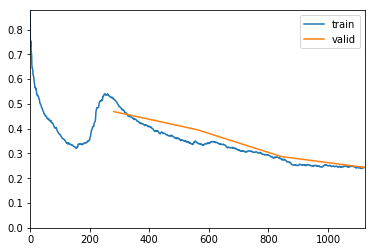

In [30]:
max_lr = 3e-2
wd = 1e-5
# 1cycle policy
learner.fit_one_cycle(cyc_len=4, max_lr=max_lr, wd=wd)

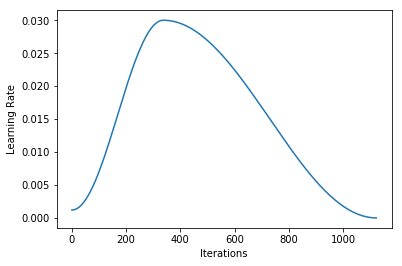

In [31]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

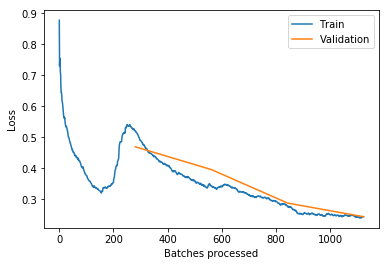

In [32]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

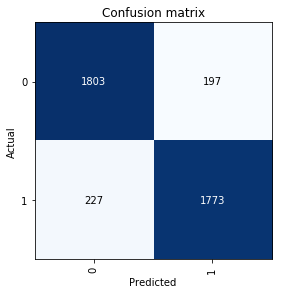

In [33]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [34]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage1')

### finetuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


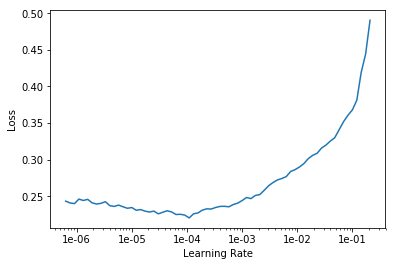

In [15]:
# load the baseline model
learner.load(MODEL_PATH + '_stage1')
#
wd = 1e-5

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

In [ ]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner.fit_one_cycle(cyc_len=8, max_lr=slice(2e-5,2e-4))

In [ ]:
learner.recorder.plot_losses()

In [ ]:
# lets take a second look at the confusion matrix. See if how much we improved.
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [ ]:
# Save the finetuned model
learner.save(MODEL_PATH + '_stage2')

### validation

In [ ]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")